Predicted class: 125, confidence: 0.002


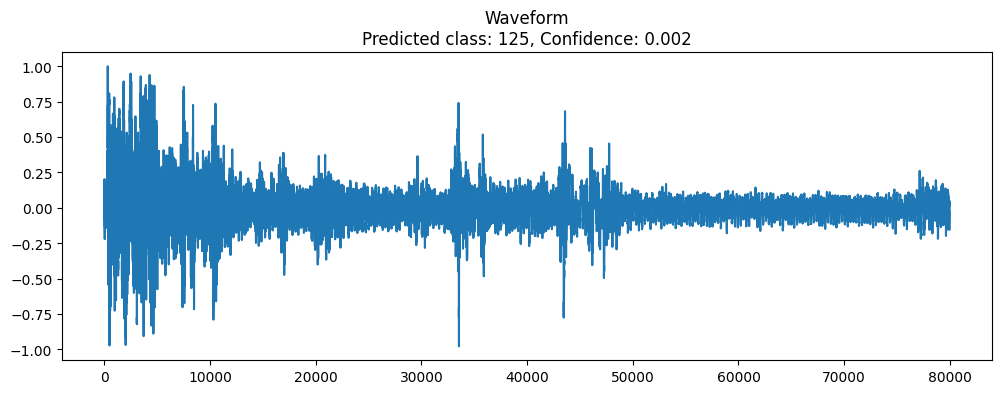

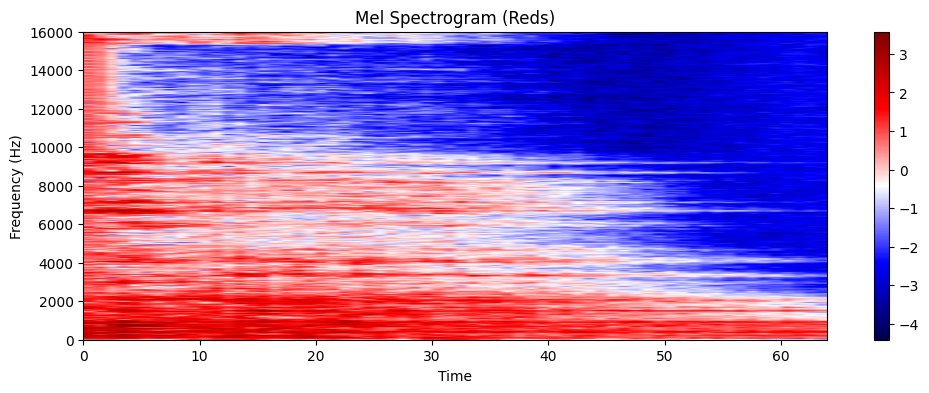

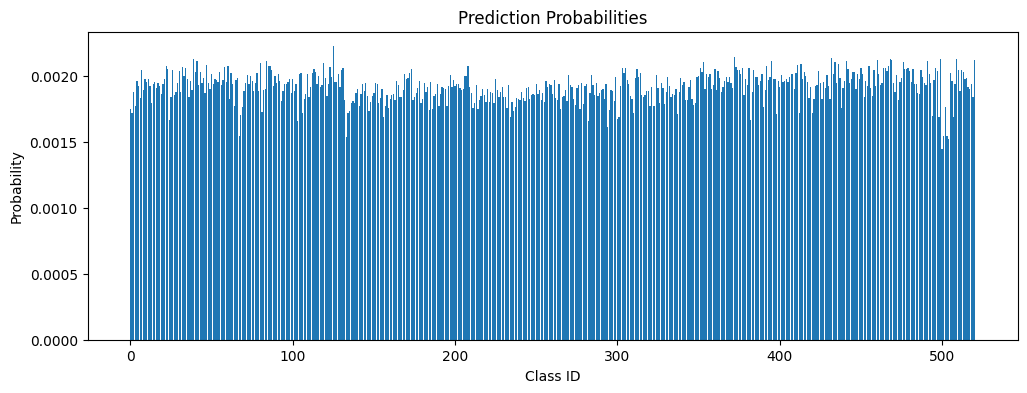

In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from srcv2full.model import YAMNet
from srcv2full.feature_extraction import WaveformToMelSpec
import srcv2full.params as params

# -----------------------------
# 1. Load your trained model
# -----------------------------
num_classes = params.NUM_CLASSES
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = YAMNet()
current_state_dict = torch.load("checkpoints/yamnet_audioset_converted.pth", map_location=device)

# fixing the state dictionary difference in converted weights and model structure
new_state_dict = {}
for k,v in current_state_dict.items():
    if k.startswith("layer."):
        parts = k.split(".")
        layer_idx = int(parts[1]) + 1
        new_key = f"layer_{layer_idx}." + ".".join(parts[2:])
        new_state_dict[new_key] = v
    else:
        new_state_dict[k] = v
        
model.load_state_dict(new_state_dict, strict=False)
model.to(device)
model.eval()

# -----------------------------
# 2. Load & preprocess an audio file
# -----------------------------
audio_path = "ESC50Artifact/audio/1-23222-A-19_hum.wav"  # replace with your audio file
waveform, sr = torchaudio.load(audio_path)

# Resample if needed
if sr != params.SAMPLE_RATE:
    waveform = torchaudio.functional.resample(waveform, sr, params.SAMPLE_RATE)

# Ensure mono
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)
waveform = waveform.to(device)  # move waveform to the same device as model and transform

# Convert waveform to Mel Spectrogram chunks
waveform_to_mel = WaveformToMelSpec(device=device)
x_chunks, mel_spectrogram = waveform_to_mel(waveform, params.SAMPLE_RATE)

# Move chunks to device
x_chunks = x_chunks.to(device)

# -----------------------------
# 3. Run forward pass
# -----------------------------
temperature = 2.0  # adjust temperature to calibrate predictions
with torch.no_grad():
    logits = model(x_chunks)  # [num_chunks, num_classes]
    scaled_logits = logits / temperature
    probs = torch.softmax(scaled_logits, dim=-1)

# Average predictions across chunks
avg_probs = probs.mean(dim=0)
pred_class = torch.argmax(avg_probs).item()
confidence = avg_probs[pred_class].item()

print(f"Predicted class: {pred_class}, confidence: {confidence:.3f}")

# -----------------------------
# 4. (Optional) Visualize waveform, spectrogram & probabilities
# -----------------------------
plt.figure(figsize=(12,4))
plt.plot(waveform.squeeze().cpu().numpy())
plt.title(f"Waveform\nPredicted class: {pred_class}, Confidence: {confidence:.3f}")
plt.show()

plt.figure(figsize=(12,4))
plt.imshow(mel_spectrogram.squeeze(), aspect='auto', origin='lower', cmap='seismic', 
           extent=[0, mel_spectrogram.shape[1], 0, params.SAMPLE_RATE])
plt.title("Mel Spectrogram (Reds)")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,4))
plt.bar(range(num_classes), avg_probs.cpu().numpy())
plt.title("Prediction Probabilities")
plt.xlabel("Class ID")
plt.ylabel("Probability")
plt.show()
